# Model Report
**PSTAT 174 Time Series Final Project**

*Coby Wilcox, 4812764*

An explanation of my model's overall architecture and ideas.

In [60]:
import tensorflow as tf
import datasets
import convtas
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
from parameters import Parameters
import librosa
import musdb
import IPython.display as ipd

## Encoder-Decoder

The main idea of Conv-TasNet revolves around a encoder-decoder convolution architecture. Where one part of the network's job is to convert the data into a lower dimensional respresentation for easier processing and generalization. Then using this lower dimensional respresentation the network will extract features from the data, that will eventually be used to reconstruct the data into its desired output. The decoder will pretty much always consist of one or more transpose convolutions.

![Overall Model Architecture](https://github.com/jambory/MSS-Project/blob/in_progress/images/convtas_architecture.png?raw=true)

In [21]:
class Encoder(tf.keras.layers.Layer):
    """ 
    First step of model not counting, preprocessing data. Puts the inputs through a 1D Convolutional layer with N output channels. The encoder also includes a activation
    function of a ReLU layer.

    Args: (taken from Parameters object)
        N (int): Encoder output channel size
        win (int): Kernel size of encoder.
        overlap (int): Amount samples each audio chunk will overlap adjacent chunks by.

    """
    def __init__(self, param: Parameters):
        super(Encoder, self).__init__(name='Encoder')
        self.U = tf.keras.layers.Conv1D(param.N,param.win,strides=param.overlap,activation="relu",use_bias=False, data_format="channels_last")

    def call(self, x): # (M, T)
        batch_count,sample_count = x.shape
        x = tf.reshape(x, (batch_count, sample_count, 1)) # (M, T, 1)
        return self.U(x) # (M, K, N)


In [ ]:
def load_display_song(mus, idx):
    track = mus[idx]
    sr = track.rate
    audio = librosa.to_mono(track.audio.T) # to mono i think i could make it stereo by just feeding each channel separately then combining.
    stems = [librosa.to_mono(track.stems[i].T) for i in range(1,5)]
    print(track.name)
    print(audio.shape)
    ipd.display(ipd.Audio(data=audio, rate=sr))

    return audio, sr, stems

In [ ]:
param = Parameters()
encoder_model = tf.keras.models.Sequential()
encoder_model.add(Encoder(param))
root_mus = '../MUSDB18'
mus = musdb.DB(download=True, subsets="test")
audio, sr, stems = load_display_song(mus, 3)

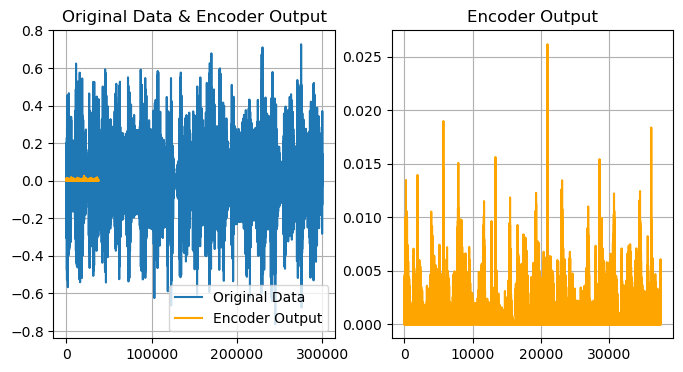

In [54]:
def enc_output_plot(encoder_model, audio):
    model_input = np.reshape(audio, (1, len(audio)))
    enc_output = encoder_model(model_input)
    fig, axes = plt.subplots(1,2, figsize=(8,4))

    axes[0].plot(audio, label='Original Data')
    axes[0].plot(enc_output[0,:,0], color='orange', label='Encoder Output')
    axes[1].plot(enc_output[0,:,0], color='orange',label='Encoder Output')

    axes[0].set_title('Original Data & Encoder Output')
    axes[0].legend()
    axes[0].grid()

    axes[1].set_title('Encoder Output')
    axes[1].grid()

    return enc_output, model_input

enc_output, model_input = enc_output_plot(encoder_model, audio)

Looking at the data size compared to the original, its easier to see how a convolved version of the data would be infinitely easier to work with. And generally with this output, when you look at it compared to the original it seems to keep most of its data. Removing negative values is a smart idea as with audio data this is will just generally be the same except inversed and we turned over 300,000 data points into around 30,000! We just downsampled our data by a factor of 10. Keep in mind also, that from the hyper parameters the model uses, the model will output 512 channels of these mini versions of the audio data, each emphasizing specific aspects of the data, while trimming the fat that channel doesn't need.

In [48]:
class Decoder(tf.keras.layers.Layer):
    """ 
    This is layer is final part of the model. Taking the features obtained, from the Conv1D blocks masks are finally combined into with the
    original mix into the estimated sources.

    Args:
        C: (int) Amount of sources being estimated
        N: (int) Encoder output channel size
        win (int): Kernel size of encoder.
        overlap (int): Amount samples each audio chunk will overlap adjacent chunks by.

    """
    def __init__(self, param: Parameters):
        super(Decoder, self).__init__(name='Decoder')
        self.C = param.C
        self.N = param.N
        self.win = param.win
        self.overlap = param.overlap


        self.transpose_conv = tf.keras.layers.Conv1DTranspose(1,self.win,strides=param.overlap,use_bias=False)

    def call(self, input): # (M, K, N) (M, C, K, N)

        output = self.transpose_conv(input) # (M, C, T)
        return output  # (M, C, T)


In [56]:
encdec_model = tf.keras.models.Sequential()
encdec_model.add(Encoder(param))
encdec_model.add(Decoder(param))

In [57]:
def encdec_output_plot(model, audio, model_input):
    output = model(model_input)
    fig, axes = plt.subplots(1,2, figsize=(8,4))

    axes[0].plot(audio, label='Original Data')
    axes[0].plot(output[0,:,0], color='orange', label='Enc-Dec Output')
    axes[1].plot(output[0,:,0], color='orange',label='Enc-Dec Output')

    axes[0].set_title('Original Data & Enc-Dec Output')
    axes[0].legend()
    axes[0].grid()

    axes[1].set_title('Enc-Dec Output')
    axes[1].grid()

    return output

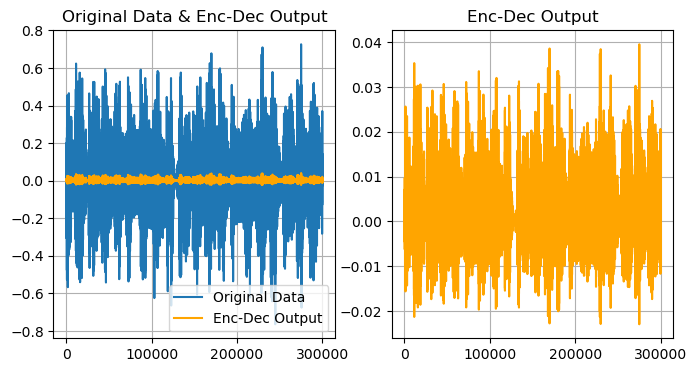

In [58]:
encdec_output = encdec_output_plot(encdec_model, audio, model_input)

And now our data is back! Is it completely accurate to how it was before? No, but I think its impressive how close it was to before considering how much the data got compressed in the encoding stage. Hopefully you can see now how the overall process works. We downsample the data into manageable chunks that accentuate certain parts of the data so the model can extract them as features then using these features, it tries its best to accomplish its goal for the model before using the decoder to put the model back into its orginal form.

## Separator

The Separator of my model is consists of several different interlocking parts that each encapsulate the other to create a multilayered down and up scaling feature extraction process. The overall architecture of the model is like this: First the encoder output in put through a normalization layer, then into a convolution called the bottleneck. After this step the data then goes through several stages of what the creators of the model called the Temporal Convolution Blocks. In each Temporal Convolution block the data is then put through several Conv1D Blocks wherein the data is downscaled and features are collected.

![Temporal Convolution Block Design](https://github.com/jambory/MSS-Project/blob/in_progress/images/separator.png?raw=true)

Image Credit to Conv-TasNet Creators Yi Luo, Nima Mesgarani

In [ ]:
class Separator(layers.Layer):
    """ 
    To begin the we take the output of the encoder which we then normalize it and feed it into a 1x1Convolution.
    This layer repeats a Temporal Convolution Block multiple times, wherin, what is refered to as a Conv1D Block in the paper, is repeated
    several times for each instance of a Temporal Convolutional Block. Finally the output of the Temporal blocks is input into a 1x1 Convolution
    with C*N output channels.
    Args:
        C: (int) Amount of sources being estimated
        N: (int) Encoder output channel size
        B: (int) Bottleneck Conv1DBlock output size
        R: (int) Amount of repeats of the Temporal Convolution block
        X: (int) Amount of times Conv1DBlock is applied in a Temporal Convolution block
        H: (int) Conv1DBlock input size
        P: (int) Size of kernel in depthwise convolutions
        Sc: (int=128) Channel size of skip connection and residual outputs.
        casual: (bool) Bool to decide what type of normalization is applied.
        skip: (bool) Bool to decide if skip connections are used.
    
    """
    def __init__(self, param: Parameters):
        super(Separator, self).__init__(name='Separator')
        self.C = param.C
        self.N = param.N
        self.skip=param.skip
        if param.casual:
            self.normalization = cLN(self.N)
        else:
            self.normalization = gLN(self.N) 
    
        self.bottle_neck = layers.Conv1D(param.B,1)
        
        self.temporal_conv = [TemporalConv(param.X, param.H, param.Sc, param.P, param.casual, skip=self.skip) for r in range(param.R)]

        self.skip_add = layers.Add()
        self.prelu = layers.PReLU()

        self.m_i = layers.Conv1D(self.C*self.N, 1)

    def call(self, w): # (M, K, N)
        M, K, _ = w.shape
        normalized_w = self.normalization(w) # (M, K, N)
        output = self.bottle_neck(normalized_w) # (M, K, B)
        if self.skip:
            skip_conn = tf.zeros(output.shape)
        for block in self.temporal_conv:
            if self.skip:
                output, skips = block(output) # (M, K, B), (M, K, B)
                skip_conn = self.skip_add([skip_conn, skips]) # (M, K, B)
            else:
                output = block(output) # (M, K, B)
        
        if self.skip:
            output = skip_conn

        output = self.prelu(output)
        estimated_masks = self.m_i(output) # (M, K, C*N)
        estimated_masks = activations.sigmoid(tf.reshape(estimated_masks, (M, self.C, K, self.N))) # (M, C, K, N)
        return estimated_masks # (M, C, K, N)

### Temporal Convolution Block

To downsample the input and get features, the model applies a Conv1DBlock X times. The outputs of the blocks are added together to encompass the skip connection features. The process of repeating the Conv1DBlocks X times and collecting features is known as a Temporal Convolution Block. This process itself is also repeated R times which is shown in the Separator.


In [ ]:
class TemporalConv(layers.Layer):
    """ 
    To downsample the input and get features, the model applies a Conv1DBlock X times. 
    The outputs of the blocks are added together to encompass the skip connection features.
    The process of repeating the Conv1DBlocks X times and collecting features is known as a
    TemporalConvolution. This process itself is also repeated R times which is shown in the Separator.

    Args: 
        X: (int) Amount of times Conv1DBlock is applied in a Temporal Convolution block
        H: (int) Conv1DBlock input size
        Sc: (int=128) Channel size of skip connection and residual outputs. Typically will be the same as B.
        P: (int) Size of kernel in depthwise convolutions
        casual: (bool) Bool to decide what type of normalization is applied.
        skip: (bool) Bool to decide if skip connections are used.
    """
    def __init__(self, X, H, Sc, P, casual, skip=True):
        super(TemporalConv,self).__init__(name='TemporalConv')
        self.skip=skip
        self.blocks = []
        for i in range(X):
            dilation = 2 ** i
            self.blocks += [Conv1DBlock(H, Sc, P, dilation, casual, skip=self.skip)]
        self.res_add = layers.Add()
        self.skip_add = layers.Add()
    
    def call(self, block_input): # (M, K, B)
        if self.skip:
            skip_conn = tf.zeros(block_input.shape) # Creates blank tensor for skip features to be added to. 
        for block in self.blocks:    
                if self.skip:
                    res, skip = block(block_input) # (M, K, Sc), (M, K, Sc)
                    block_input = self.res_add([block_input, res]) # (M, K, Sc)
                    skip_conn = self.skip_add([skip_conn,skip]) # (M, K, Sc)
                else:
                    res = block(block_input) # (M, K, Sc)
                    block_input = self.res_add([block_input, res]) # (M, K, Sc)
        if self.skip:
            return block_input, skip_conn # (M, K, Sc), (M, K, Sc)
        else:
            return block_input # (M, K, Sc)

### Conv1D Block

The Conv1D Blocks are the main feature extractor process of the model. The structure is to take its input, change the channels to H w/ a PReLu, then normalize, perform a Depthwise Convolution then finally add the features the residuals from the input to create a skip connected feature set. Finally it should be noted that in the original paper and in this implementation, we use a slightly modified convolution called a Depthwise convolution. 

![Conv1d Design](https://github.com/jambory/MSS-Project/blob/in_progress/images/conv1dblock.png?raw=true)

Image Credit to Conv-TasNet Creators Yi Luo, Nima Mesgarani

In [ ]:
class Conv1DBlock(layers.Layer):
    """ 
    Conv1D block as described in this paper: https://arxiv.org/pdf/1809.07454v3. The structure is to take its input, change the channels
    to H w/ a PReLu, then normalize, perform a Depthwise Convolution then finally add the features the residuals from the input to create a 
    skip connected feature set.

    Args: 
        H: (int) Conv1DBlock input size
        Sc: (int=128) Channel size of skip connection and residual outputs.
        P: (int) Size of kernel in depthwise convolutions
        dilation: (int) Power 2 int, to decide dilation factor of convolution.
        casual: (bool) Bool to decide what type of normalization is applied.
        skip: (bool) Bool to decide if skip connections are used.

    Returns:
        (res, skip) or res ()

    """
    def __init__(self, H, Sc, P, dilation, casual, skip = True):
        super(Conv1DBlock, self).__init__(name='Conv1DBlock')
        self.skip = skip
        self.input_channels = layers.Conv1D(H,1)
        self.prelu = layers.PReLU()
        if casual:
            self.norm = cLN(H)
        else:
            self.norm = gLN(H)
        
        self.depthwise = DepthwiseConv(H, Sc, P, dilation, casual, skip=self.skip)
        self.res_add = layers.Add()

    def call(self, input): # (M, K, B/Sc)
        input_channels = self.input_channels(input) # (M, K, H)
        input_channels = self.prelu(input_channels)
        input_channels = self.norm(input_channels)
        if self.skip:
            res, skip = self.depthwise(input_channels)  # (M, K, Sc),(M, K, Sc)
            res = self.res_add([res, input]) # (M, K, Sc)
            return res, skip 

        res = self.depthwise(input_channels, skip=self.skip) # (M, K, Sc)
        res = self.res_add([res, input]) # (M, K, Sc)
        return res # (M, K, Sc)

### Depthwise Convolutions

A depthwise convolutional layer. The intuition of using a depthwise convolution over a normal convolution layer is as follows. 
    
Typically for a convolution what you end up creating is K x K x C kernel(s), where each kernel spans the basic kernel size amongst every input channel. The depthwise convolution makes a K x K x 1 kernel specifically for each input channel. So the number of output channels generally should always be the same as the input channel number. 

Then take this output and perform a 1x1 convolution (essentially a dense layer), and make the number of output neurons be your initially desired output channel size and you get your depthwise convolution.

It has the benefit of sometimes requiring less parameters to train.

In [ ]:
class DepthwiseConv(layers.Layer):
    """ 
    A depthwise convolutional layer. The intuition of using a depthwise convolution over a normal
    convolution layer is as follows. 
    
    Typically for a convolution what you end up creating is K x K x C kernel(s),
    where each kernel spans the basic kernel size amongst every input channel. The depthwise convolution makes a K x K x 1
    kernel specifically for each input channel. So the number of output channels generally should always be the same as the input
    channel number. 

    Then take this output and perform a 1x1 convolution (essentially a dense layer), and make the number of output neurons be
    your initially desired output channel size and you get your depthwise convolution.

    It has the benefit of sometimes requiring less parameters to train.

    Args:
        H: (int) Conv1DBlock input size
        Sc: (int=128) Channel size of skip connection and residual outputs.
        P: (int) Size of kernel in depthwise convolutions
        dilation: (int) Power 2 int, to decide dilation factor of convolution.
        casual: (bool) Bool to decide what type of normalization is applied.
        skip: (bool) Bool to decide if skip connections are used.
    """
    def __init__(self, H, Sc, P, dilation, casual, skip=True):
        super(DepthwiseConv, self).__init__(name='DepthwiseConv')
        self.skip = skip
        if casual:
            padding_type = "causal"
            self.norm = cLN(H)
        else:
            padding_type = "same"
            self.norm = gLN(H)

        self.conv1d = layers.Conv1D(H, P, dilation_rate=dilation, padding=padding_type, groups=H)
        self.prelu = layers.PReLU()
        
        self.res_out = layers.Dense(Sc)
        if self.skip:
            self.skip_out = layers.Dense(Sc)
    
    def call(self, input): # (M, K, H)
        output = self.conv1d(input) # (M, K, H)
        output = self.prelu(output)
        output = self.norm(output)
        res = self.res_out(input) # (M, K, Sc)
        if self.skip:
            skip_out = self.skip_out(output) # (M, K, Sc)
            return res, skip_out # (M, K, Sc), (M, K, Sc)
        else:
            return res # (M, K, Sc)